<a href="https://colab.research.google.com/github/ssuppe/bloogsugarml/blob/main/2)_Binary_Classification_of_Diabetes_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification of diabetes diagnosis

This is a 'thematic replication' of the Binary classification exercise. Rather than trying to identify types of rice grain, I am using a [Diabetes dataset](https://www.openml.org/search?type=data&sort=runs&id=43483&status=active) from OpenML, originally from the National Institute of Diabetes and Digestive and Kidney Diseases.

The goal here is simple binary classification of whether or not candidate is diabetic or not based on features related to health (pregnancies, blood pressure, etc)

# Findings/summary
* By using Glucose, Insulin and BMI I was able to get a test recall of 100% (!) and precision of 0.497 (prediction threshold of 0.2). Recall of 100% seems a bit like we are overfitting, but OTOH it doesn't surprise me that glucose and insulin esp would be great predictors of diabetes.
  * accuracy: 0.6597
  * auc: 0.8408
  * loss: 0.4762
  * precision: 0.4972
  * recall: 0.9418

* Recall (how many diabetics are we identifying) is very high. 95% - 100% of all 'true' diabetics are captured. However, precision is ~0.5. This means every time we say someone is diabetic, *we are wrong 50% of the time*. However, this could still be a great diagnostic test for determining which of your patients needs to come in for further testing (blood testing, etc). So depending on cost profile of treatment this might be a great first diagnostic.

* Interestingly, when using all features, recall went down dramatically and precision only improved a little bit.


In [103]:
#@title Load imports

import io
import keras
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import plotly.express as px
import requests
# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format


In [104]:
#@title Load the dataset
import re
from io import StringIO

raw = requests.get("https://www.openml.org/data/download/22102308/dataset")
dre = re.compile(r"(?:@DATA)(.*)", re.MULTILINE | re.DOTALL)
data = pd.read_csv(StringIO(re.search(dre,raw.text).group(1)), header=None)
data.columns = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","Outcome"]
data


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  \
0            6.0    148.0           72.0           35.0    169.5 33.6   
1            1.0     85.0           66.0           29.0    102.5 26.6   
2            8.0    183.0           64.0           32.0    169.5 23.3   
3            1.0     89.0           66.0           23.0     94.0 28.1   
4            0.0    137.0           40.0           35.0    168.0 43.1   
..           ...      ...            ...            ...      ...  ...   
763         10.0    101.0           76.0           48.0    180.0 32.9   
764          2.0    122.0           70.0           27.0    102.5 36.8   
765          5.0    121.0           72.0           23.0    112.0 26.2   
766          1.0    126.0           60.0           32.0    169.5 30.1   
767          1.0     93.0           70.0           31.0    102.5 30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                         0.6 50.0      1.0  
1                         0.4 31.0      0.0  
2                         0.7 32.0      1.0  
3                         0.2 21.0      0.0  
4                         2.3 33.0      1.0  
..                        ...  ...      ...  
763                       0.2 63.0      0.0  
764                       0.3 27.0      0.0  
765                       0.2 30.0      0.0  
766                       0.3 47.0      1.0  
767                       0.3 23.0      0.0  

[768 rows x 9 columns]


- **Glucose**: Glucose ( 140) = Normal, Glucose (140-200) = Pre-Diabetic, Glucose ( 200) = Diabetic
- **BloodPressure**: B.P ( 60) = Below Normal, B.P (60-80) = Normal, B.P (80-90) = Stage 1 Hypertension, B.P (90-120) = Stage 2 Hypertension, B.P ( 120) = Hypertensive Crisis
- **SkinThickness**: SkinThickness ( 10) = Below Normal, SkinThickness (10-30) = Normal, SkinThickness ( 30) = Above Normal
- **Insulin**: Insulin ( 200) = Normal, Insulin ( 200) = Above Normal
- **BMI**: BMI ( 18.5) = Underweight, BMI (18.5-25) = Normal, BMI (25-30) = Overweight, BMI ( 30) = Obese

In [105]:
#@title Task 1: Describe the data

In [106]:
data.describe()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
count        768.0    768.0          768.0          768.0    768.0 768.0   
mean           3.8    121.7           72.4           29.1    141.8  32.4   
std            3.4     30.5           12.1            8.9     89.1   6.9   
min            0.0     44.0           24.0            7.0     14.0  18.2   
25%            1.0     99.8           64.0           25.0    102.5  27.5   
50%            3.0    117.0           72.0           28.0    102.5  32.0   
75%            6.0    140.2           80.0           32.0    169.5  36.6   
max           17.0    199.0          122.0           99.0    846.0  67.1   

       DiabetesPedigreeFunction   Age  Outcome  
count                     768.0 768.0    768.0  
mean                        0.5  33.2      0.3  
std                         0.3  11.8      0.5  
min                         0.1  21.0      0.0  
25%                         0.2  24.0      0.0  
50%                         0.4  29.0      0.0  
75%                         0.6  41.0      1.0  
max                         2.4  81.0      1.0

##### Findings
* I am no expert here, but wanted to do some quick sanity checking
* With the exception of # of pregnancies, there are no candidates with any measurements of 0, which I think would be physically impossible
* 17 pregnancies seems REALLY high, but it is possible I suppose with miscarriages
* Glucose levels seem reasonable (although I'm surprised 199 is the max, but maybe these are all T2Ds. 199 is not 'that high' for type 1 at times

# Explore the dataset

Plot some of the features against each other, including in 3D

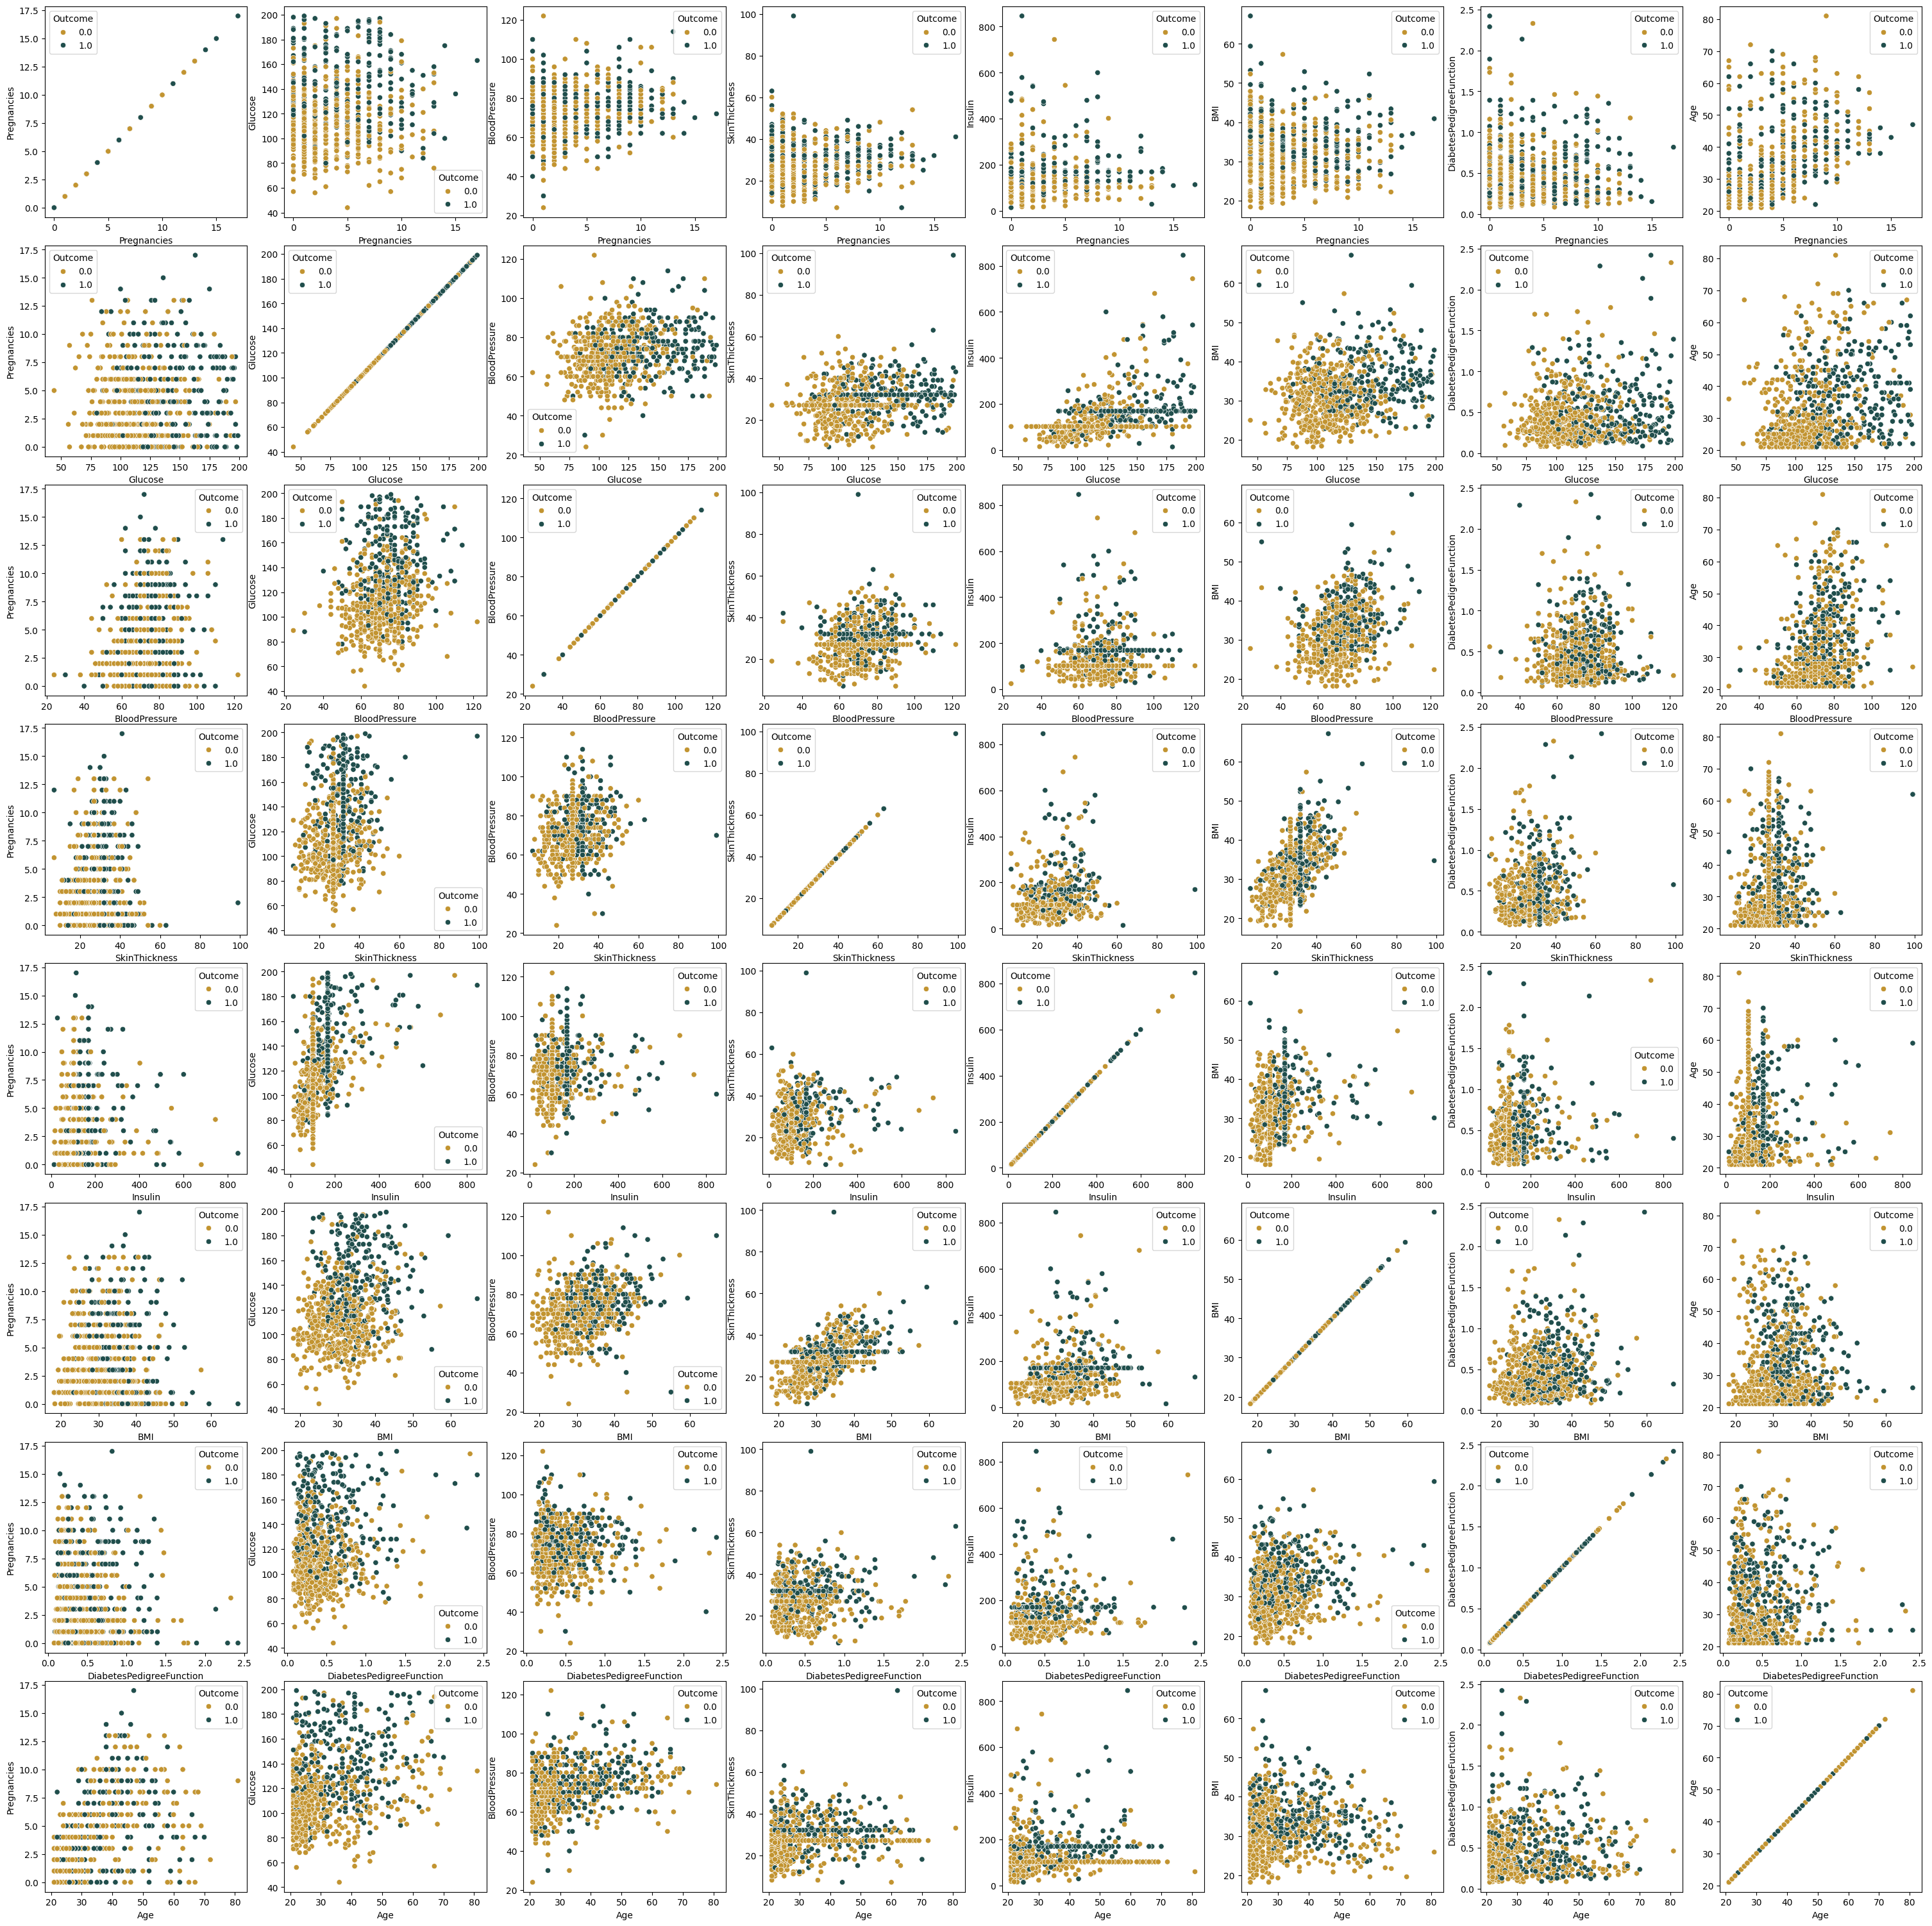

In [107]:
import seaborn
features_all = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
colors = ["#c29431", "#204e4c"]
fig, axes = plt.subplots(8, 8, figsize=(30,30))
fig.tight_layout()

for i, f1 in enumerate(features_all):
  for j, f2 in enumerate(features_all):
    seaborn.scatterplot(data=data, x=f1, y=f2, hue='Outcome', palette=colors, ax=axes[i][j])

## Findings

IMHO there are not a lot of obviously correlated factors, but a couple that visually look promising:
* Glucose to BMI
* BMI to blood pressure
* Age to blood pressure

Let's look at the correlation matrix

Pregnancies  Glucose  BloodPressure  SkinThickness  \
Pregnancies                       1.0      0.1            0.2            0.1   
Glucose                           0.1      1.0            0.2            0.2   
BloodPressure                     0.2      0.2            1.0            0.2   
SkinThickness                     0.1      0.2            0.2            1.0   
Insulin                           0.1      0.5            0.1            0.2   
BMI                               0.0      0.2            0.3            0.6   
DiabetesPedigreeFunction         -0.0      0.1           -0.0            0.1   
Age                               0.5      0.3            0.3            0.1   
Outcome                           0.2      0.5            0.2            0.3   

                          Insulin  BMI  DiabetesPedigreeFunction  Age  Outcome  
Pregnancies                   0.1  0.0                      -0.0  0.5      0.2  
Glucose                       0.5  0.2                       0.1  0.3      0.5  
BloodPressure                 0.1  0.3                      -0.0  0.3      0.2  
SkinThickness                 0.2  0.6                       0.1  0.1      0.3  
Insulin                       1.0  0.2                       0.1  0.1      0.4  
BMI                           0.2  1.0                       0.2  0.0      0.3  
DiabetesPedigreeFunction      0.1  0.2                       1.0  0.0      0.2  
Age                           0.1  0.0                       0.0  1.0      0.2  
Outcome                       0.4  0.3                       0.2  0.2      1.0

<Axes: >

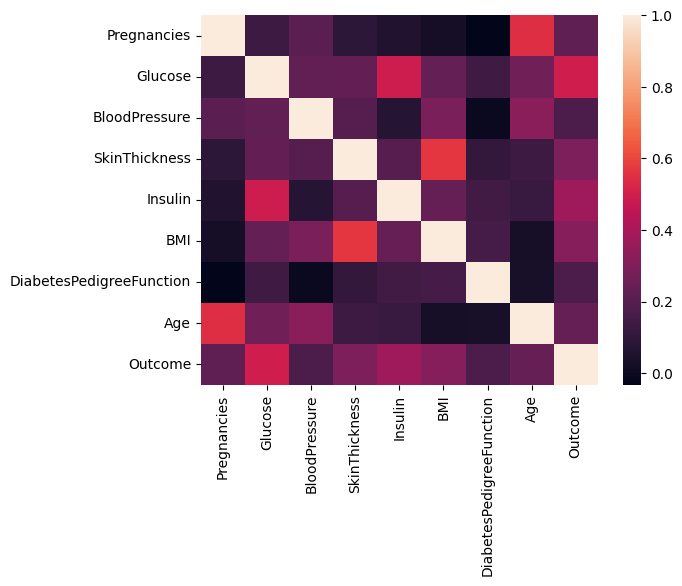

In [108]:
display(data.corr())
seaborn.heatmap(data.corr())

## Findings

Glucose is an obvious correlation to Outcome. I didn't look at the scatter plots where the features were the same and I should have.

Pregnancy and age, glucose and insulin, skin thickness to BMI are the obvious ones, although others have small correlation

# 3-D plots

Unfortunately I can't seem to make interactive 3-d plots in a subplot model, so each one of these is a figure:

In [115]:
#@title Plot three features in 3D by entering their names and running this cell
# Age
# BMI
# BloodPressure
# DiabetesPedigreeFunction
# Glucose
# Insulin
# Pregnancies
# SkinThickness



x_axis_data = 'BMI'  # @param {type: "string"}
y_axis_data = 'Insulin'  # @param {type: "string"}
z_axis_data = 'Glucose'  # @param {type: "string"}

px.scatter_3d(
    data,
    x=x_axis_data,
    y=y_axis_data,
    z=z_axis_data,
    color='Outcome',
).show()

In [110]:
#@title Plot three features in 3D by entering their names and running this cell
# Age
# BMI
# BloodPressure
# DiabetesPedigreeFunction
# Glucose
# Insulin
# Pregnancies
# SkinThickness



x_axis_data = 'Insulin'  # @param {type: "string"}
y_axis_data = 'Glucose'  # @param {type: "string"}
z_axis_data = 'BMI'  # @param {type: "string"}

px.scatter_3d(
    data,
    x=x_axis_data,
    y=y_axis_data,
    z=z_axis_data,
    color='Outcome',
).show()

I don't see any obvious indicators that create clean separations. I tried by holding 2 features constant and iterating through the 3rd, as well as just a lot of random selections. I would have liked to have done a nested for loop and enumerated all the options but it's just too many.

## Normalize data

When creating a model with multiple features, the values of each feature should span roughly the same range.  If one feature's values range from 500 to 100,000 and another feature's values range from 2 to 12, the model will need to have weights of extremely low or extremely high values to be able to combine these features effectively. This could result in a low quality model.  To avoid this,
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model.

This can be done by converting each raw value to its Z-score. The **Z-score** for a given value is how many standard deviations away from the mean the value is.

Consider a feature with a mean of 60 and a standard deviation of 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

Now normalize the numerical values in the rice dataset by converting them to Z-scores.

In [111]:
# Calculate the Z-scores of each numerical column in the raw data and write
# them into a new DataFrame named df_norm.

feature_mean = data[features_all].mean()
feature_std = data[features_all].std()
# numerical_features = data.select_dtypes('number').columns
normalized_dataset = (
    data[features_all] - feature_mean
) / feature_std

# Copy the class to the new dataframe
normalized_dataset['Outcome'] = data['Outcome']

# Examine some of the values of the normalized training set. Notice that most
# Z-scores fall between -2 and +2.
normalized_dataset.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  \
0          0.6      0.9           -0.0            0.7      0.3  0.2   
1         -0.8     -1.2           -0.5           -0.0     -0.4 -0.8   
2          1.2      2.0           -0.7            0.3      0.3 -1.3   
3         -0.8     -1.1           -0.5           -0.7     -0.5 -0.6   
4         -1.1      0.5           -2.7            0.7      0.3  1.6   

   DiabetesPedigreeFunction  Age  Outcome  
0                       0.5  1.4      1.0  
1                      -0.4 -0.2      0.0  
2                       0.6 -0.1      1.0  
3                      -0.9 -1.0      0.0  
4                       5.5 -0.0      1.0

# Set the random seeds

To make experiments reproducible, we set the seed of the random number generators. This means that the order in which the data is shuffled, the values of the random weight initializations, etc, will all be the same each time the colab is run.

This is optional

In [112]:
keras.utils.set_random_seed(42)

# Label and split data

Randomize and partition the dataset into train, test, and validation splits, consisting of 80%, 10%, and 10% of the dataset respectively.

In [113]:
# Create indices at the 80th and 90th percentiles
number_samples = len(normalized_dataset)
index_80th = round(number_samples * 0.8)
index_90th = index_80th + round(number_samples * 0.1)

# Randomize order and split into train, validation, and test with a .8, .1, .1 split
shuffled_dataset = normalized_dataset.sample(frac=1, random_state=100)
train_data = shuffled_dataset.iloc[0:index_80th]
validation_data = shuffled_dataset.iloc[index_80th:index_90th]
test_data = shuffled_dataset.iloc[index_90th:]

# Show the first five rows of the last split
test_data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  \
36           2.1      0.5            0.3           -0.2     -0.4  0.1   
180          0.6     -1.1            0.6           -0.2     -0.4 -1.3   
176          0.6     -1.2            0.5           -0.2     -0.4 -0.2   
700         -0.5      0.0            0.3           -0.2      0.7  0.5   
495          0.6      1.5            0.1           -0.2     -0.4 -0.8   

     DiabetesPedigreeFunction  Age  Outcome  
36                       -0.2  0.1      0.0  
180                      -1.2 -0.1      0.0  
176                      -0.3  0.7      0.0  
700                       0.0 -0.6      0.0  
495                      -0.5  2.8      0.0

It's important to prevent the model

---

from getting the label as input during training, which is called label leakage. This can be done by storing features and labels as separate variables.

In [114]:
label_columns = ['Outcome']

train_features = train_data.drop(columns=label_columns)
train_labels = train_data['Outcome'].to_numpy()
validation_features = validation_data.drop(columns=label_columns)
validation_labels = validation_data['Outcome'].to_numpy()
test_features = test_data.drop(columns=label_columns)
test_labels = test_data['Outcome'].to_numpy()

display(len(train_features))
display(len(train_labels))

display(len(validation_features))
display(len(validation_labels))

display(len(test_features))
display(len(test_labels))

614

614

77

77

77

77

# Train the model

In [117]:
# Name of the features we'll train our model on.
input_features = [
    'Glucose',
    'Insulin',
    'BMI',
]

## Define functions that build and train a model

The following code cell defines two functions:

  * `create_model(inputs, learning_rate, metrics)`, which defines the model's architecture.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

Note: create_model applies the sigmoid function to perform [logistic regression](https://developers.devsite.corp.google.com/machine-learning/ml-crash-course/logistic-regression).

We also define two helpful data structures: `ExperimentSettings` and `Experiment`. We use these simple classes to keep track of our experiments, allowing us to know what hyperparameters were used and what the results were. In `ExperimentSettings`, we store all values describing an experiment (i.e., hyperparameters). Then, we store the results of a training run (i.e., the model and the training metrics) into an `Experiment` instance, along with the `ExperimentSettings` used for that experiment.

In [119]:
# @title Define the functions that create and train a model.

import dataclasses


@dataclasses.dataclass()
class ExperimentSettings:
  """Lists the hyperparameters and input features used to train am model."""

  learning_rate: float
  number_epochs: int
  batch_size: int
  classification_threshold: float
  input_features: list[str]


@dataclasses.dataclass()
class Experiment:
  """Stores the settings used for a training run and the resulting model."""

  name: str
  settings: ExperimentSettings
  model: keras.Model
  epochs: np.ndarray
  metrics_history: keras.callbacks.History

  def get_final_metric_value(self, metric_name: str) -> float:
    """Gets the final value of the given metric for this experiment."""
    if metric_name not in self.metrics_history:
      raise ValueError(
          f'Unknown metric {metric_name}: available metrics are'
          f' {list(self.metrics_history.columns)}'
      )
    return self.metrics_history[metric_name].iloc[-1]


def create_model(
    settings: ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
  """Create and compile a simple classification model."""
  model_inputs = [
      keras.Input(name=feature, shape=(1,))
      for feature in settings.input_features
  ]
  # Use a Concatenate layer to assemble the different inputs into a single
  # tensor which will be given as input to the Dense layer.
  # For example: [input_1[0][0], input_2[0][0]]

  concatenated_inputs = keras.layers.Concatenate()(model_inputs)
  dense = keras.layers.Dense(
      units=1, input_shape=(1,), name='dense_layer', activation=keras.activations.sigmoid
  )
  model_output = dense(concatenated_inputs)
  model = keras.Model(inputs=model_inputs, outputs=model_output)
  # Call the compile method to transform the layers into a model that
  # Keras can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(
      optimizer=keras.optimizers.RMSprop(
          settings.learning_rate
      ),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics,
  )
  return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    labels: np.ndarray,
    settings: ExperimentSettings,
) -> Experiment:
  """Feed a dataset into the model in order to train it."""

  # The x parameter of keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.
  features = {
      feature_name: np.array(dataset[feature_name])
      for feature_name in settings.input_features
  }

  history = model.fit(
      x=features,
      y=labels,
      batch_size=settings.batch_size,
      epochs=settings.number_epochs,
  )

  return Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )


print('Defined the create_model and train_model functions.')

Defined the create_model and train_model functions.


In [120]:
# @title Define the plotting function.
def plot_experiment_metrics(experiment: Experiment, metrics: list[str]):
  """Plot a curve of one or more metrics for different epochs."""
  plt.figure(figsize=(12, 8))

  for metric in metrics:
    plt.plot(
        experiment.epochs, experiment.metrics_history[metric], label=metric
    )

  plt.xlabel("Epoch")
  plt.ylabel("Metric value")
  plt.grid()
  plt.legend()


## Invoke the creating, training, and plotting functions

The following code specifies the hyperparameters, invokes the
functions to create and train the model, then plots the results, including accuracy, precision, and recall.

Classification threshold is set at .35. Try playing with the threshold, then the learning rate, to see what changes.

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3992 - auc: 0.7936 - loss: 0.5782 - precision: 0.3575 - recall: 0.9996
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4718 - auc: 0.8264 - loss: 0.5280 - precision: 0.3880 - recall: 0.9996
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5153 - auc: 0.8355 - loss: 0.5052 - precision: 0.4076 - recall: 0.9749 
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5684 - auc: 0.8383 - loss: 0.4930 - precision: 0.4365 - recall: 0.9749 
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5906 - auc: 0.8400 - loss: 0.4863 - precision: 0.4501 - recall: 0.9635 
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6101 - auc: 0.8411 - loss: 0.4825 - precision: 0.4625 - recall: 0.9561 
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6207 - auc: 0.8416 - loss: 0.4803 - precision: 0.4697 - recall: 0.9466
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

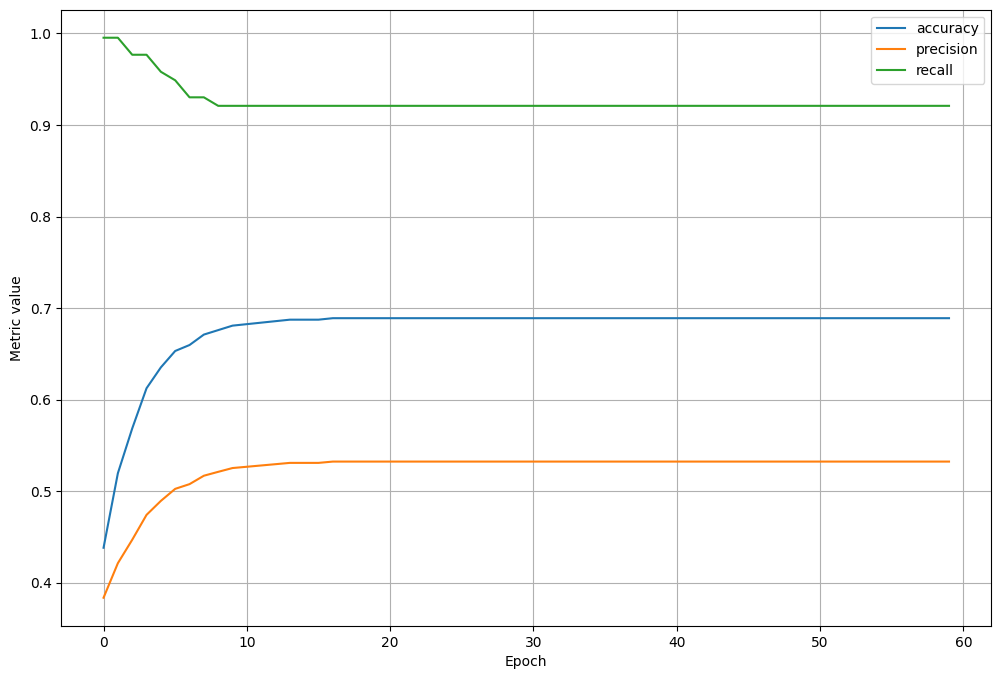

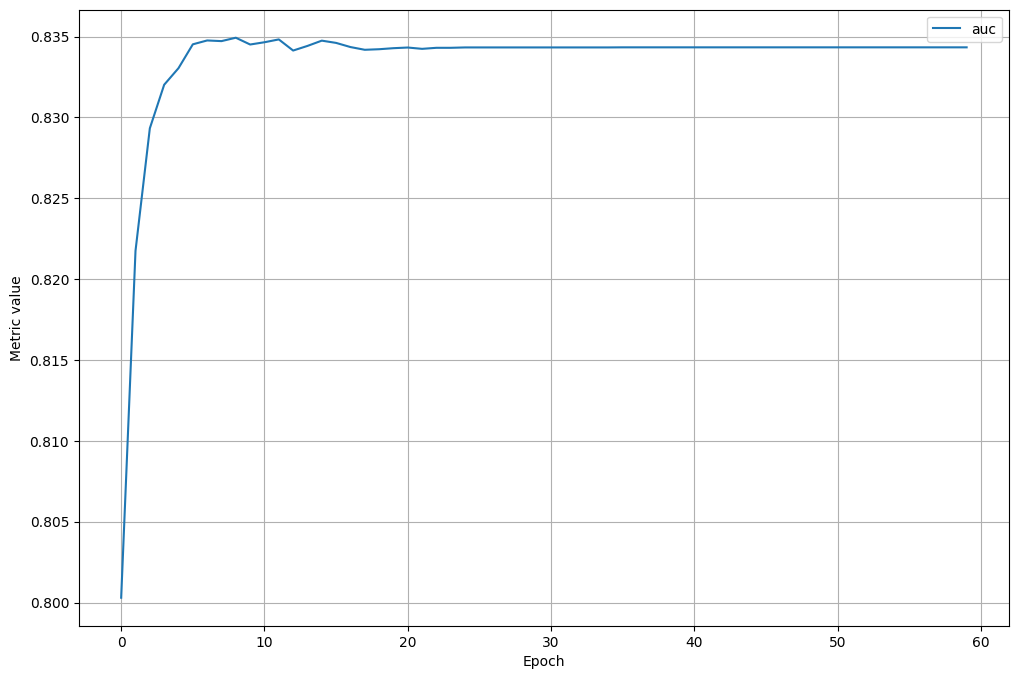

In [124]:
# Let's define our first experiment settings.
settings = ExperimentSettings(
    learning_rate=0.01,
    number_epochs=60,
    batch_size=25,
    classification_threshold=0.2,
    input_features=input_features,
)

metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy', threshold=settings.classification_threshold
    ),
    keras.metrics.Precision(
        name='precision', thresholds=settings.classification_threshold
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model = create_model(settings, metrics)

# Train the model on the training set.
experiment = train_model(
    'baseline', model, train_features, train_labels, settings
)

# Plot metrics vs. epochs
plot_experiment_metrics(experiment, ['accuracy', 'precision', 'recall'])
plot_experiment_metrics(experiment, ['auc'])

P/R of ~0.6 / .75 isn't TERRIBLE but it isn't all that great either (with classification threshold of 0.35)

Will try changing classification threshold now.

With classification threshold at 0.2:
accuracy: 0.6597 - auc: 0.8408 - loss: 0.4762 - precision: 0.4972 - recall: 0.9418

Recall (how many diabetics are we identifying) is very high. 95% of all 'true' diabetics are captured. However, precision is ~0.5. This means every time we say someone is diabetic, we are wrong 50% of the time. This might be good if this was a quick test to decide if more tests were needed.

Let's see how it does against the test set.

In [131]:
def evaluate_experiment(
    experiment: Experiment, test_dataset: pd.DataFrame, test_labels: np.array
) -> dict[str, float]:
  features = {
      feature_name: np.array(test_dataset[feature_name])
      for feature_name in experiment.settings.input_features
  }
  return experiment.model.evaluate(
      x=features,
      y=test_labels,
      batch_size=settings.batch_size,
      verbose=0, # Hide progress bar
      return_dict=True,
  )


def compare_train_test(experiment: Experiment, test_metrics: dict[str, float]):
  print('Comparing metrics between train and test:')
  for metric, test_value in test_metrics.items():
    print('------')
    print(f'Train {metric}: {experiment.get_final_metric_value(metric):.4f}')
    print(f'Test {metric}:  {test_value:.4f}')


# Evaluate test metrics
test_metrics = evaluate_experiment(experiment, test_features, test_labels)
compare_train_test(experiment, test_metrics)

Comparing metrics between train and test:
------
Train accuracy: 0.6889
Test accuracy:  0.7143
------
Train auc: 0.8343
Test auc:  0.9034
------
Train loss: 0.4865
Test loss:  0.4326
------
Train precision: 0.5323
Test precision:  0.5686
------
Train recall: 0.9209
Test recall:  1.0000


Quite good I think! In general it outperforms.

Can we do better by training on all features?

Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4721 - auc: 0.7877 - loss: 0.5961 - precision: 0.3872 - recall: 0.9714 
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5911 - auc: 0.8308 - loss: 0.5261 - precision: 0.4508 - recall: 0.9648
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6186 - auc: 0.8448 - loss: 0.4969 - precision: 0.4691 - recall: 0.9561 
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6318 - auc: 0.8504 - loss: 0.4800 - precision: 0.4776 - recall: 0.9253 
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6528 - auc: 0.8535 - loss: 0.4699 - precision: 0.4927 - recall: 0.9103 
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6616 - auc: 0.8555 - loss: 0.4638 - precision: 0.5002 - recall: 0.9020 
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6725 - auc: 0.8563 - loss: 0.4601 - precision: 0.5084 - recall: 0.9008
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

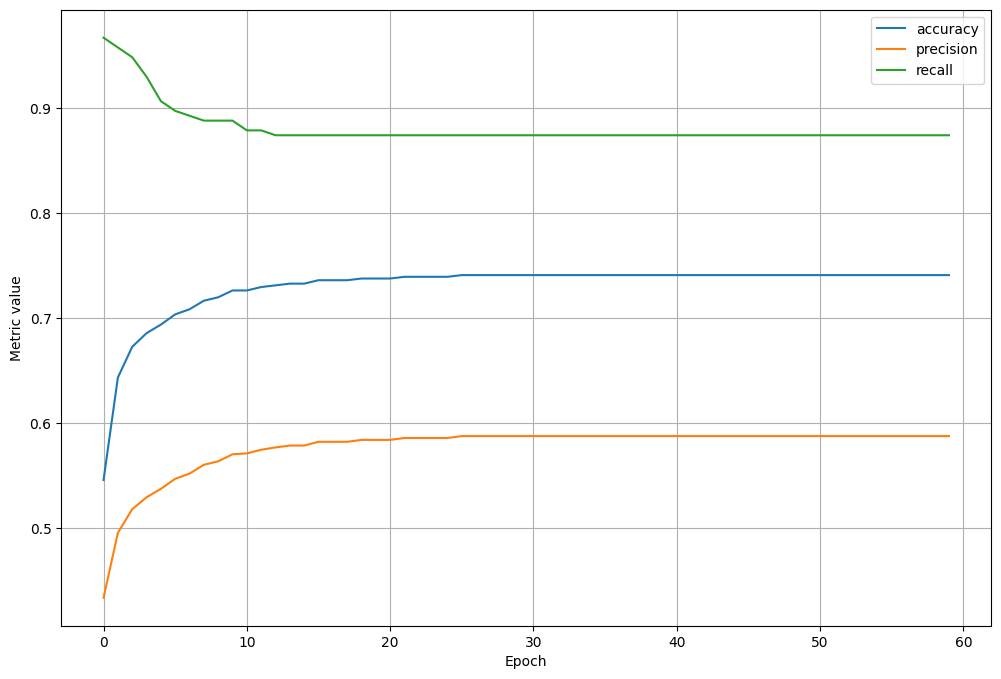

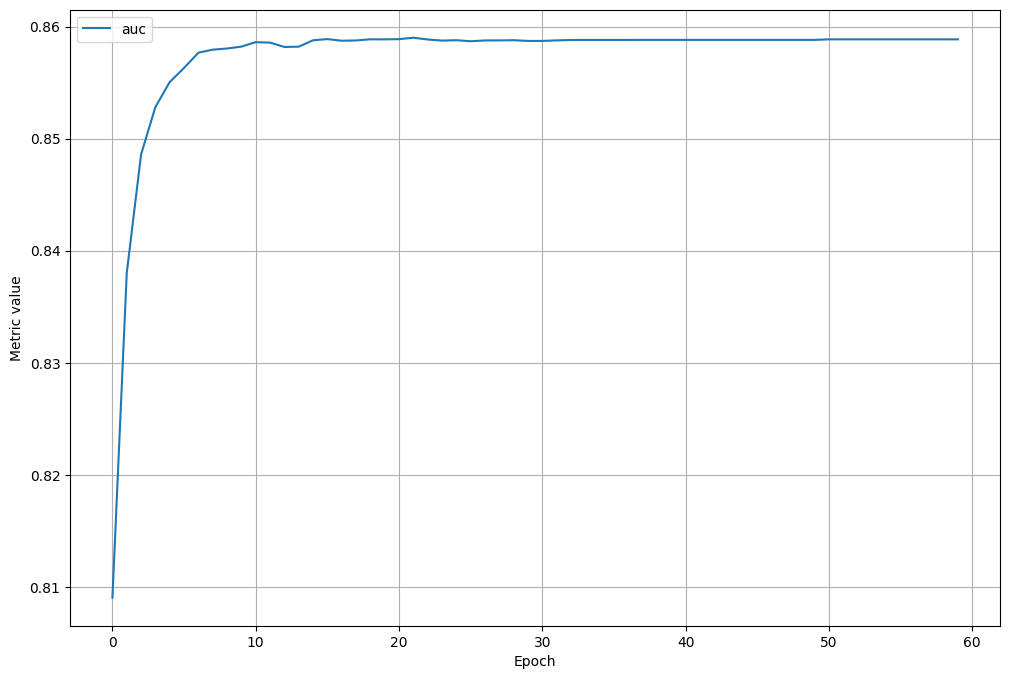

In [134]:
settings_all_features = ExperimentSettings(
    learning_rate=0.01,
    number_epochs=60,
    batch_size=25,
    classification_threshold=0.25,
    input_features=features_all,
)

metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy',
        threshold=settings_all_features.classification_threshold,
    ),
    keras.metrics.Precision(
        name='precision',
        thresholds=settings_all_features.classification_threshold,
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings_all_features.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model_all_features = create_model(settings_all_features, metrics)

# Train the model on the training set.
experiment_all_features = train_model(
    'all features',
    model_all_features,
    train_features,
    train_labels,
    settings_all_features,
)

# Plot metrics vs. epochs
plot_experiment_metrics(
    experiment_all_features, ['accuracy', 'precision', 'recall']
)
plot_experiment_metrics(experiment_all_features, ['auc'])